In [1]:
from IPython.display import display, HTML
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import wilcoxon, mannwhitneyu, ks_2samp

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB 
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.stats import pearsonr

# decision trees
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import io, os , sys, types
import copy

import seaborn as sns
sns.set(color_codes=True)

# importing custom notebooks here
import import_ipynb as imppy
sys.meta_path.append(imppy.NotebookFinder())
from analytics_functions import *
from starcon_functions import *
from helper_functions import *
# import starcon_functions

# print in a tabulated pretty manner
from tabulate import tabulate

importing Jupyter notebook from analytics_functions.ipynb
importing Jupyter notebook from starcon_functions.ipynb


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
cwd = os.getcwd()
fname_raw = r'dataset\PlanetDatabase.csv'
data_raw = pd.read_csv(fname_raw)
data_raw = data_raw[data_raw.Cluster != 'Sol']  # Removing Sol system, since it is irrelevant
data_raw.reset_index(inplace=True, drop=True)
# data_raw = data_raw.iloc[:,1:].copy(deep=True)
fontsz = 14
DEBUG = False

In [4]:
"""Divide columns to numerical and categorical"""
cols_data = list(data_raw.columns.values)
col_class = 'MinValue' # expects [0, 1] values
cols_data.remove(col_class)
cols_numeric_all = list(data_raw.describe().columns.values) # all the numerical variables
cols_categoric_all = list(set(data_raw.columns.values) - set(cols_numeric_all) - set([col_class]))

#cols_numeric = ['X', 'Y', 'DistSol', 'MinVolume', 'BioUnits', 'DistFromStar' ]
#cols_categoric = ['Cluster', 'Star', 'StarColor', 'Fleet']

##cols_numeric = ['MinVolume', 'DistFromStar']
cols_numeric = ['DistFromStar']
##cols_categoric = ['StarColor', 'Fleet', 'StarSize']
cols_categoric = ['StarColor', 'StarSize']
col_Planet = 'Planet'  # Need to convert this one to numeric

data_numeric = data_raw[cols_numeric].copy(deep=True)
data_categoric = data_raw[cols_categoric].copy(deep=True)

"""Mapping values to class (low, high)"""
data_class = data_raw[col_class]
data_class_mapped = resource_to_discrete_value(data_class, 500)

"""Convert Planet designations to numerical values"""
"""Create feature: isMoon. Then drop MoonNumber"""
planets_numeric = convert_planet_to_planet_moon(data_raw, 'Planet', ['PlanetNumber', 'MoonNumber'])
planets_numeric['isMoon'] = isMoon(planets_numeric, 'MoonNumber')
planets_numeric.drop(['MoonNumber'], axis=1, inplace=True)
data_numeric = pd.concat([data_numeric, planets_numeric] , axis=1)

"""Convert categorical to dummy variables"""
data_dummies = dummify_variables(data_categoric)

Number of columns before dummy-variables:	2
Number of columns after dummy-variables:	9


In [5]:
"""Create train and test sets"""
cols_features = data_dummies.columns.values
dataset = pd.concat([data_numeric,  data_dummies],axis=1)
x_train, y_train, x_test, y_test = train_test_datasets(dataset, data_class_mapped, 0.6, 1013)

### Decision Tree

In [21]:
cols_features = x_train.columns.values

md = 5                    # maximum tree depth
mf = len(cols_features)    # maximum number of features to consider
min_leaf = 10
criterion = 'entropy'
model = tree.DecisionTreeClassifier(max_depth=md, max_features=mf, criterion=criterion, 
                                    min_samples_leaf=min_leaf, random_state=1984,
                                   class_weight={0.0: 0.25, 1.0: 0.75})

clf = model.fit(x_train, y_train)
predicted = model.predict(x_test)
predicted_prob = model.predict_proba(x_test)[:, 1]

In [22]:
importance = model.feature_importances_
df_importance = pd.DataFrame(data=importance, index=cols_features, columns=['importance'])
df_importance = df_importance[df_importance['importance'] != 0]
# sort by feature importance
df_importance = df_importance.reindex(df_importance['importance'].abs().sort_values(ascending=False).index)
display(df_importance)

# Visualize the tree
write_Tree('dataset', clf, x_train.columns.values) 

,importance
StarColor_white,0.262598
StarColor_blue,0.209944
StarColor_green,0.205397
DistFromStar,0.108549
StarSize_dwarf,0.081928
PlanetNumber,0.047382
StarColor_yellow,0.042937
isMoon,0.021773
StarSize_super giant,0.019491


Area-Under-Curve: 0.6997


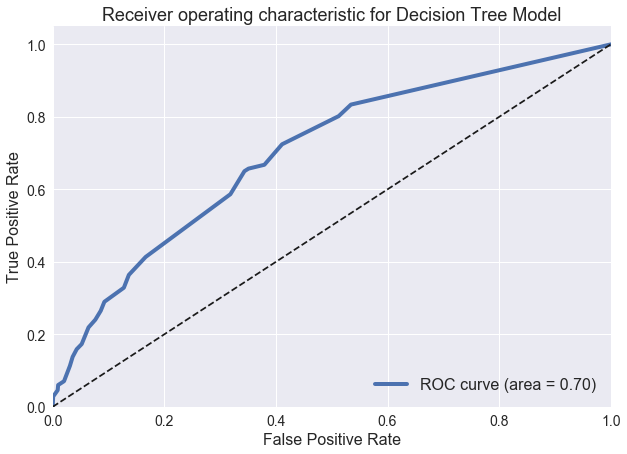

In [23]:
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), predicted_prob)
auc = metrics.auc(fpr,tpr)
print ("Area-Under-Curve:", round(auc,4))
plot_ROC(fpr,tpr, fontsz, "Receiver operating characteristic for Decision Tree Model") 

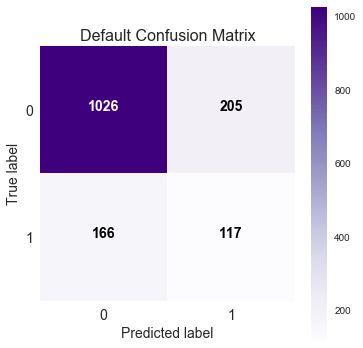

In [24]:
def_cfm = metrics.confusion_matrix(y_test, predicted) 
plot_confusion_matrix(def_cfm,['bad', 'good'], "Default Confusion Matrix", 0)

### Naive Bayes

In [10]:
gnb = BernoulliNB()
model = gnb.fit(x_train, y_train)
predicted = model.predict(x_test)
predicted_prob = model.predict_proba(x_test)[:, 1]

model_coefficients = model.coef_[0]
df_coeffs = pd.DataFrame(data=model_coefficients, index=cols_features, columns=['coeff'])
# sort by coefficients absolute value
df_coeffs = df_coeffs.reindex(df_coeffs['coeff'].abs().sort_values(ascending=False).index)
display(df_coeffs)

,coeff
StarSize_super giant,-3.012262
StarColor_orange,-2.760947
StarColor_red,-2.591048
StarColor_yellow,-2.560276
StarSize_giant,-2.419198
StarColor_green,-1.431811
StarColor_blue,-1.311852
StarColor_white,-1.252763
isMoon,-0.847298
StarSize_dwarf,-0.145987


Area-Under-Curve: 0.7071


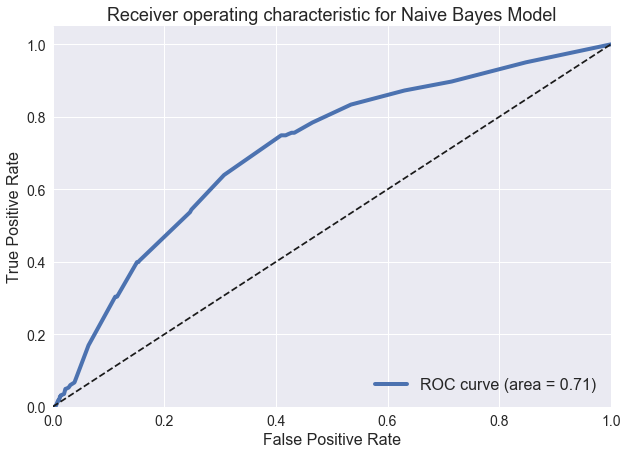

In [11]:
fpr, tpr, _ = metrics.roc_curve(np.array(y_test), predicted_prob)
auc = metrics.auc(fpr,tpr)
print ("Area-Under-Curve:", round(auc,4))
plot_ROC(fpr,tpr, fontsz, 'Receiver operating characteristic for Naive Bayes Model') 

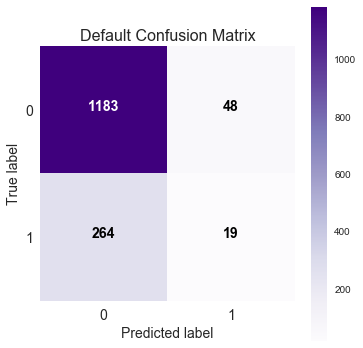

In [12]:
def_cfm = metrics.confusion_matrix(y_test, predicted) 
plot_confusion_matrix(def_cfm,['bad', 'good'], "Default Confusion Matrix", 0)